# 3D Image Segmentation
Image segmentation in 3D is challenging for several reasons: In many microscopy imaging techniques, image quality varies in space: For example intensity and/or contrast degrades the deeper you image inside a sample. Furthermore, touching nuclei are hard to differentiate in an automated way. Last but not least, anisotropy is difficult to handle depending on the applied algorithms and respective given parameters. Some algorithms, like the [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) approach demonstrated here, only work for isotropic data.

In [1]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

import napari
from napari.utils import nbscreenshot

# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

To demonstrate the workflow, we're using cropped and resampled image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

In [2]:
input_image = imread("../../data/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

For visualisation purposes we show intensity projections along X, Y and Z.

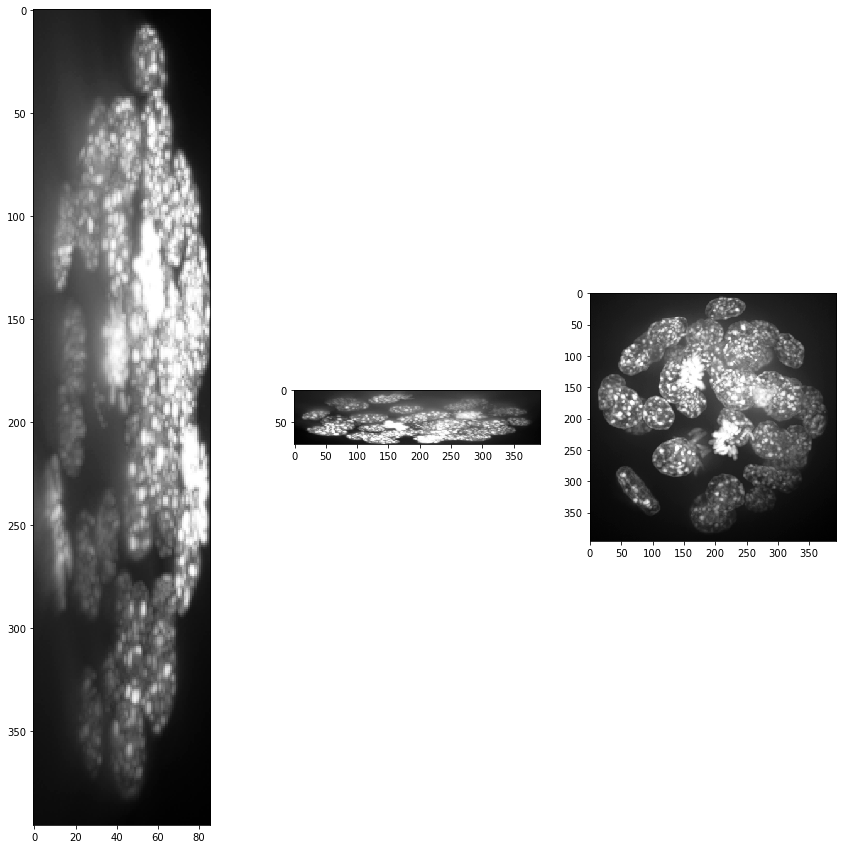

(86, 396, 393)


In [3]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

show(input_image)
print(input_image.shape)

Obviously, voxel size is not isotropic. Thus, we scale the image with the voxel size used as scaling factor to get an image stack with isotropic voxels.

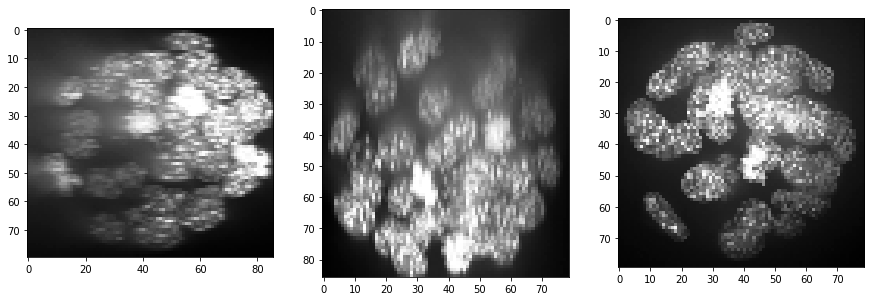

(86, 80, 79)


In [4]:
resampled = cle.scale(input_image, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)

show(resampled)
print(resampled.shape)

Furthermore, background intensity appears to increase, potentially a result if more scattering deep in the sample. We can compensate for that by using a background subtraction technique:

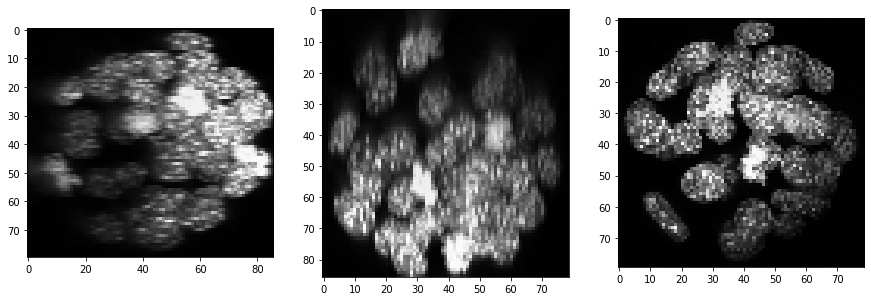

In [5]:
backgrund_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

## Segmentation


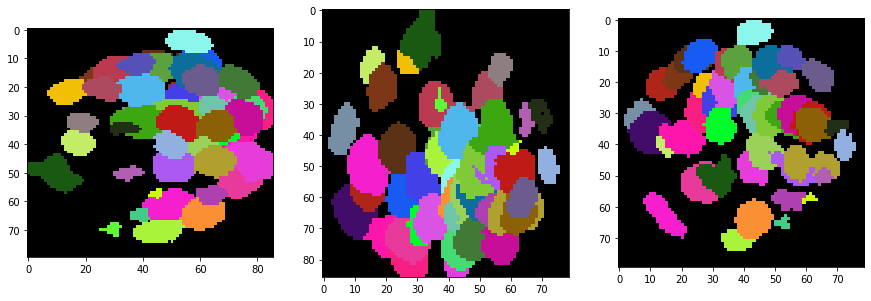

In [6]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

As segmentation results are hard to inspect in 3D, we generate an image stack with the original intensities + outlines of the segmentation. We show this stack for a couple of slices.

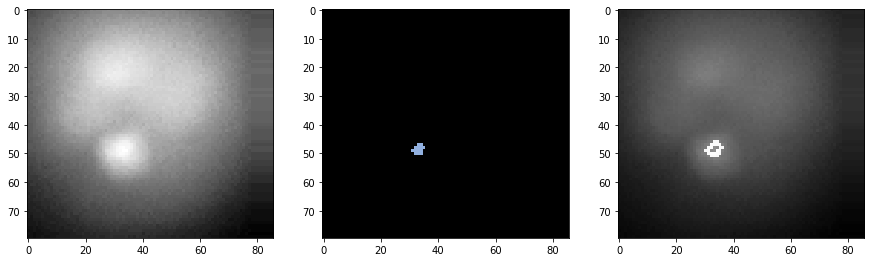

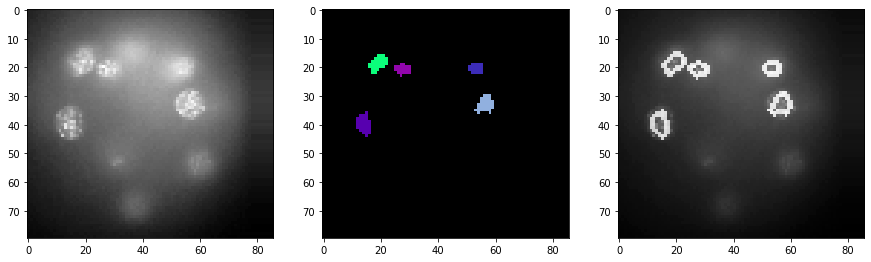

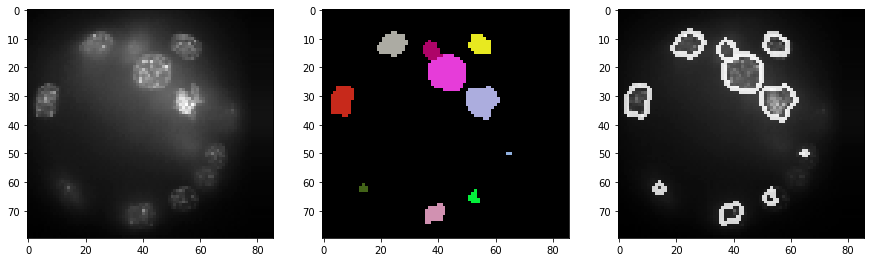

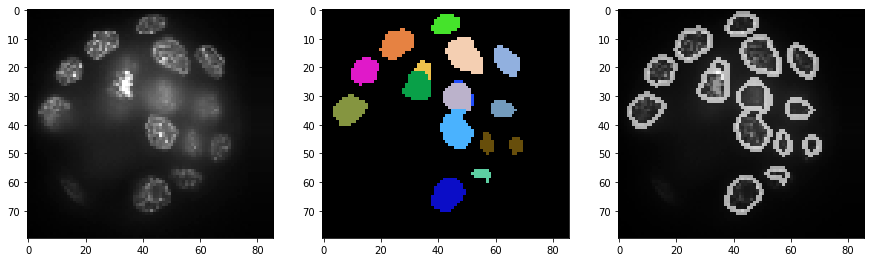

In [7]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # get a single slice from the intensity image and the segmented label image
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # determine outlines around labeled objects
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # combine both images
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # visualisation
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

## Visualization in 3D
For actual visualization in 3D you can also use [napari](https://napari.org/).

In [8]:
# start napari
viewer = napari.Viewer()

# show images
viewer.add_image(resampled)
viewer.add_labels(segmented)

<Labels layer 'segmented' at 0x2a91c57a130>

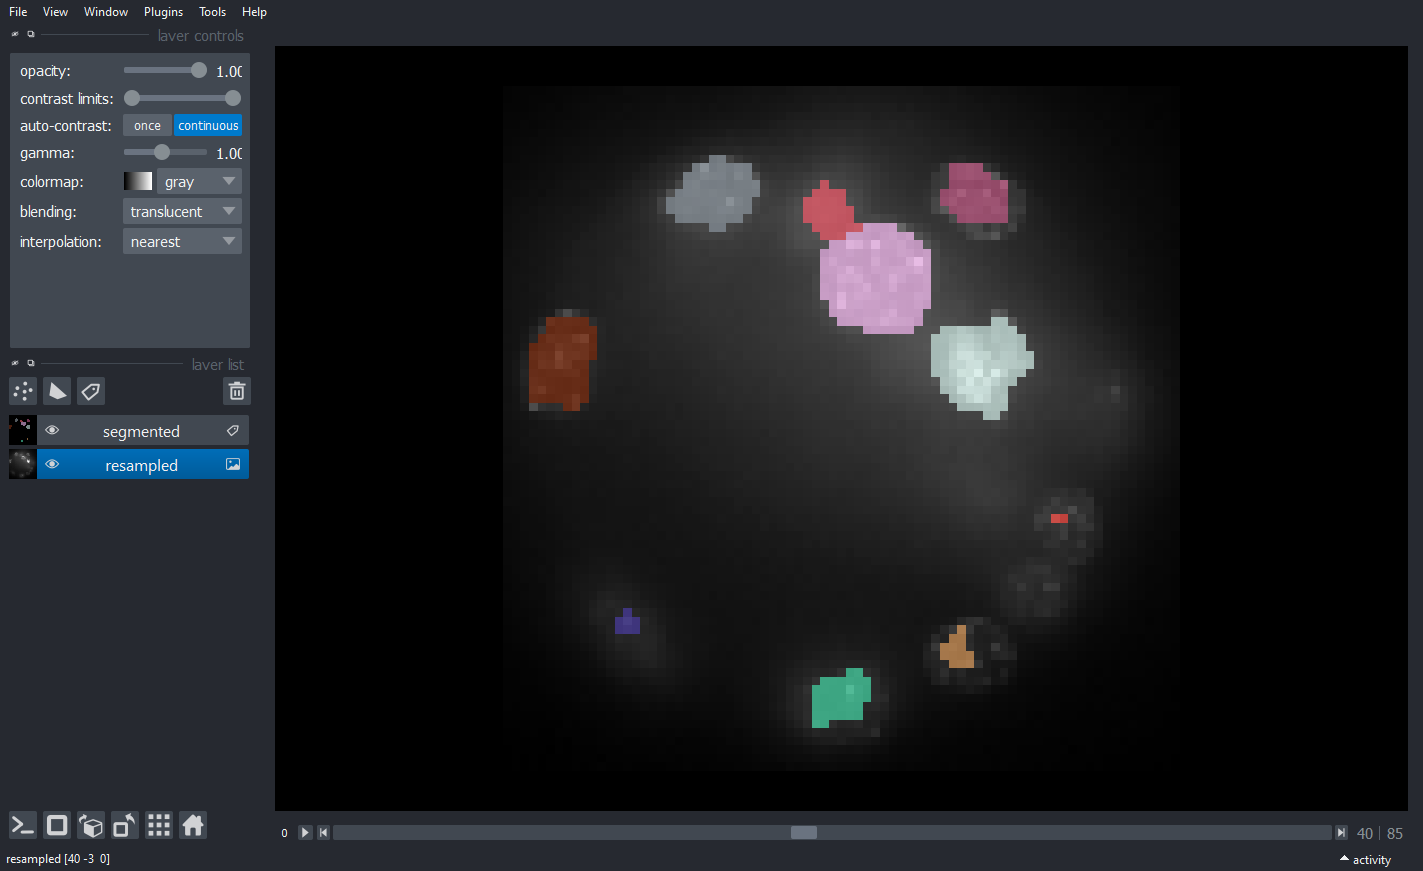

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [12]:
viewer.dims.current_step = (40, 0, 0)
nbscreenshot(viewer)

We can switch to a 3D view by clicking on the 3D button in the bottom left corner.

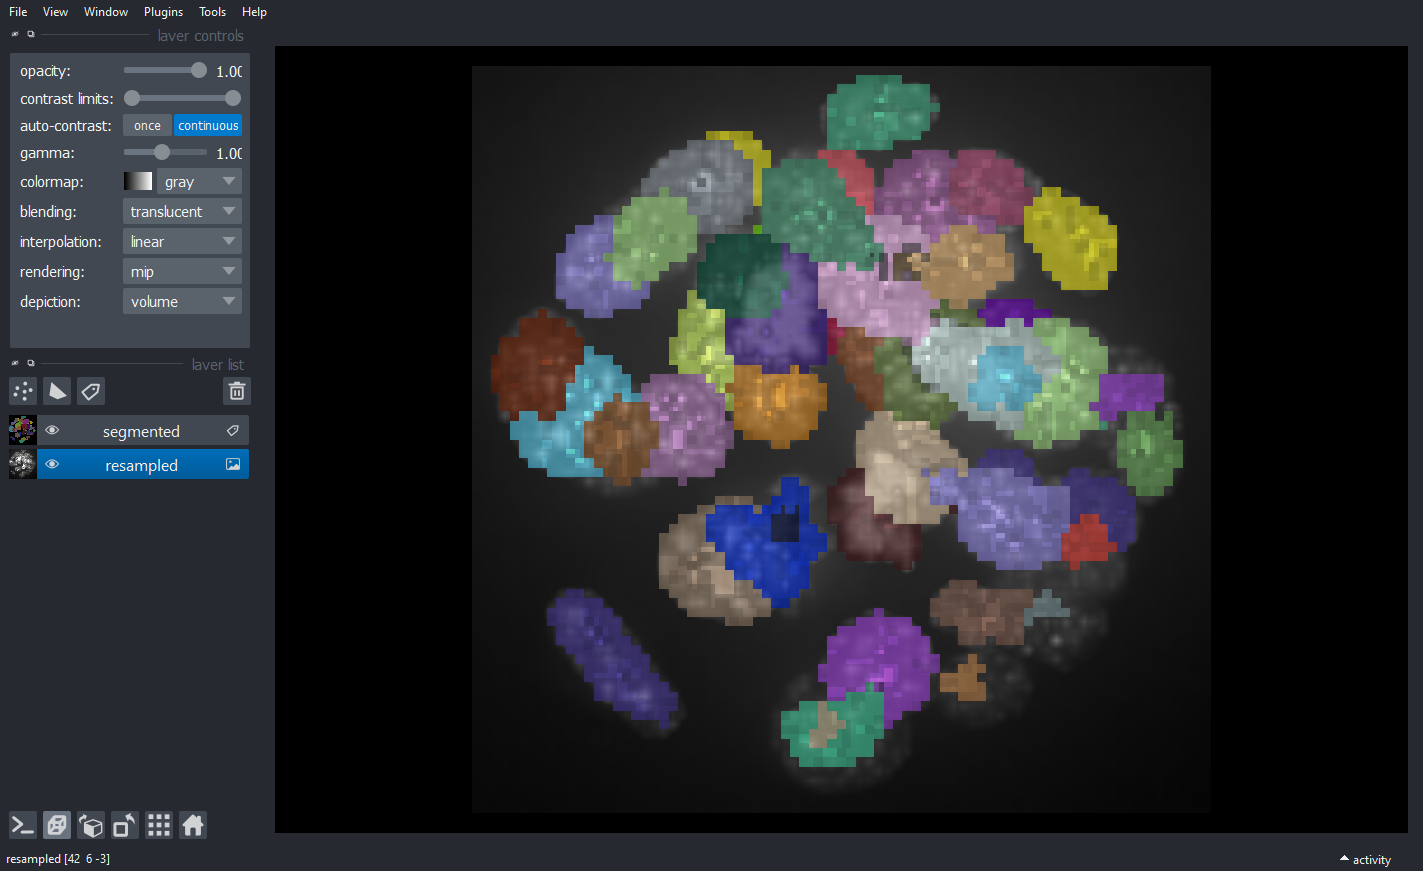

In [13]:
nbscreenshot(viewer)

We can then also tip and tilt the view.

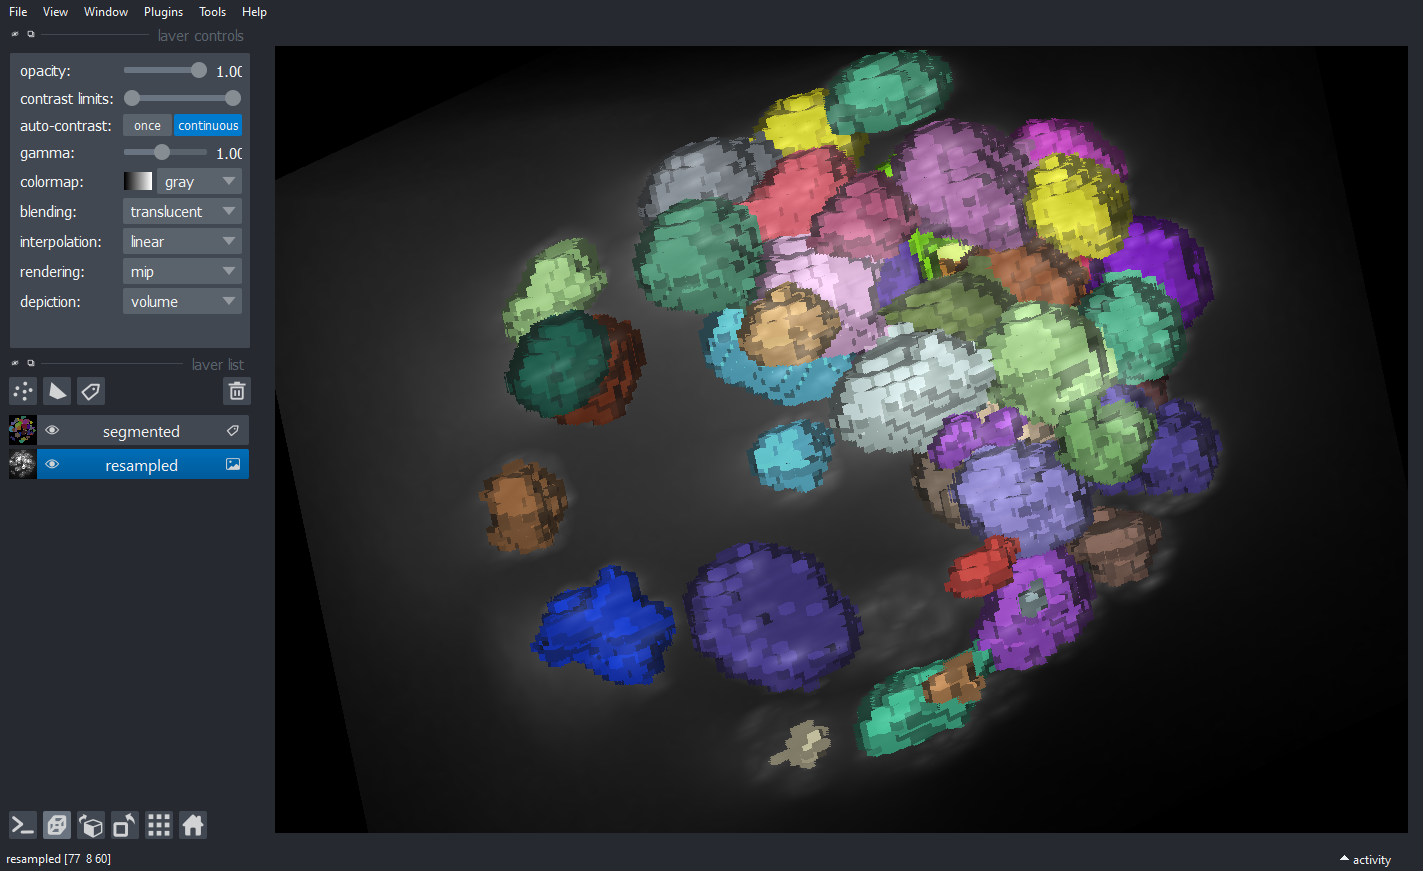

In [14]:
nbscreenshot(viewer)

## Exercise
How many cells have been segmented in this 3D image stack?